# 1. Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

from pytorch3d.ops import cubify, vert_align, GraphConv
from pytorch3d.utils import ico_sphere

from resnet50_head import Resnet50Head
from voxel_head import VoxelHead
from utils_coords import voxel_to_world, get_blender_intrinsic_matrix
from mesh_head import MeshRefinementHead

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# add path for demo utils functions 
import sys
sys.path.append(os.path.abspath(''))

from utils.plot_image_grid import image_grid

# 2. 3D Dataset (As Target)

## Load object

In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
dataset_mesh = load_objs_as_meshes([obj_filename], device=device)

## Normalize cow dataset

In [3]:
# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = dataset_mesh.verts_packed()

print("--- verts ---")
print(verts)
print(verts.shape)

N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
dataset_mesh.offset_verts_(-center)
dataset_mesh.scale_verts_((1.0 / float(scale)));

print("--- verts normalized ---")
print(verts)
print(verts.shape)

--- verts ---
tensor([[ 0.3488, -0.3350, -0.0832],
        [ 0.3131, -0.3991,  0.8812],
        [ 0.2668,  0.1816,  0.1227],
        ...,
        [-0.0132, -0.0889,  1.0422],
        [-0.0137, -0.0943,  1.0340],
        [-0.0137, -0.0796,  1.0469]], device='cuda:0')
torch.Size([2930, 3])
--- verts normalized ---
tensor([[ 0.3488, -0.3350, -0.0832],
        [ 0.3131, -0.3991,  0.8812],
        [ 0.2668,  0.1816,  0.1227],
        ...,
        [-0.0132, -0.0889,  1.0422],
        [-0.0137, -0.0943,  1.0340],
        [-0.0137, -0.0796,  1.0469]], device='cuda:0')
torch.Size([2930, 3])


## Render multiple views

In [4]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

torch.cuda.empty_cache()

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = dataset_mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

print(target_images.shape)

torch.Size([20, 128, 128, 4])


## Visualize dataset

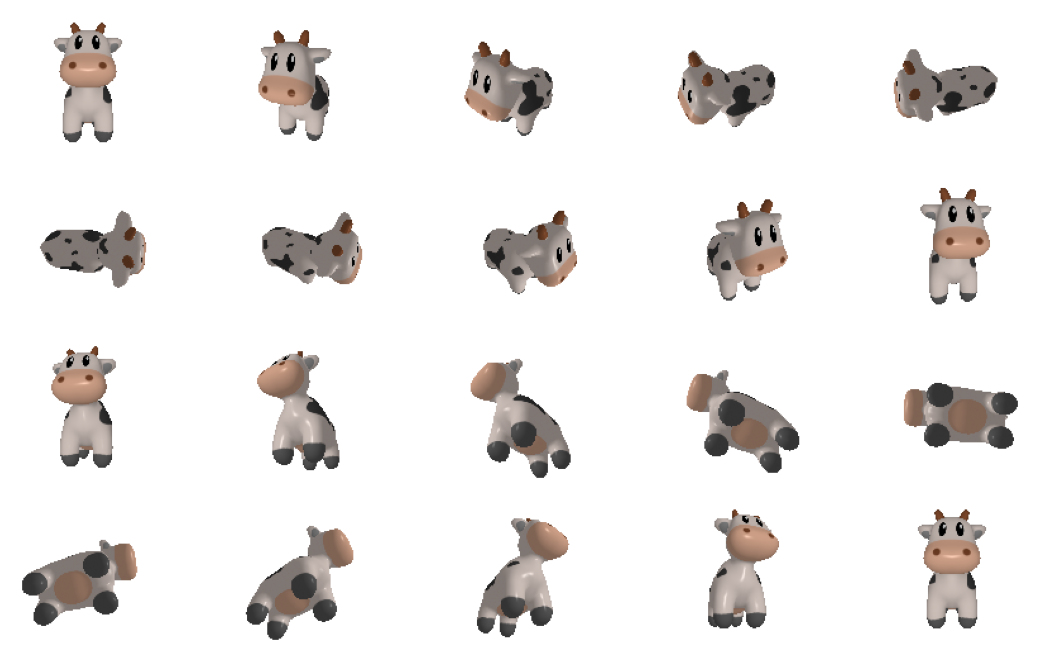

In [5]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show() 

## Dataset Silhouette (As Target)

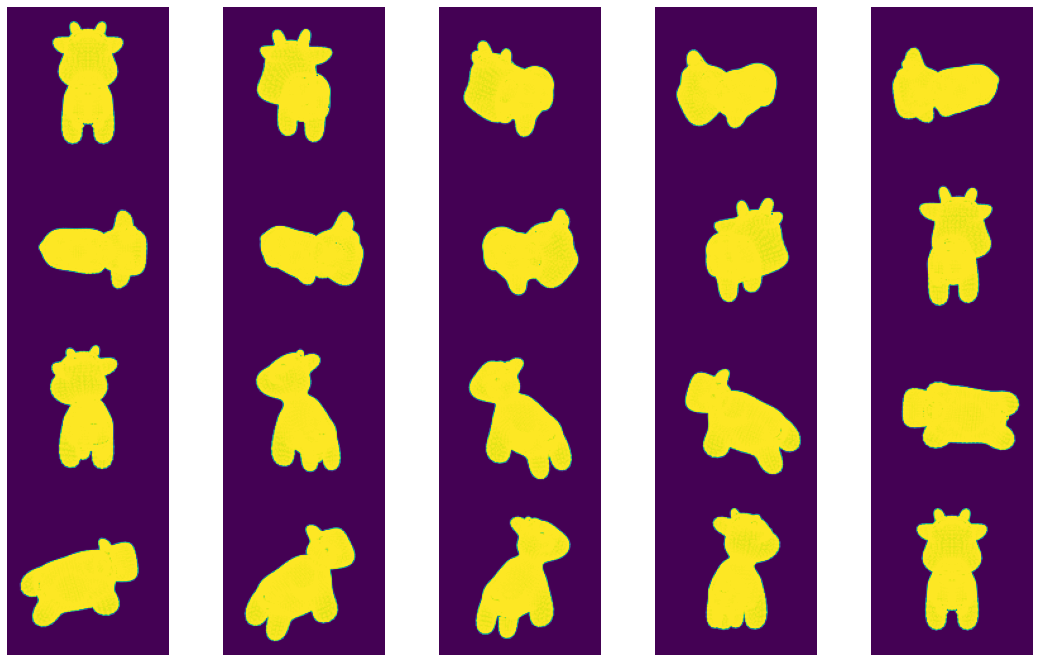

In [6]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

# 3. 2D Image Input and Preprocess

In [7]:
# ------ OPEN FILE ------
filename = "cow - 137 x 137 - v2.jpg"
input_image = Image.open(filename)

# ------ PREPROCESS ------
preprocess = transforms.Compose([
    transforms.Resize(137),
    transforms.CenterCrop(137),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# 4. Loop Settings

## A. Rasterization and Rendering Settings

In [8]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128, # was 128
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, # was 50
    perspective_correct=False # added to avoid training breaking down
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)

## B. Models

In [9]:
# ------ MODEL ------
# (2 - 5) RESNET50
resnet50_head = Resnet50Head()

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet50_head.to('cuda')


# (6 - 7) BILINEAR INTERPOLATION - VOXEL PREDICTION
voxel_head = VoxelHead()

if torch.cuda.is_available():
    voxel_head.to('cuda')

# (8) CUBIFY
# (no model, just tensor manipulation)

# (9 - 11) REFINEMENT STAGES 1 - 3
mesh_head = MeshRefinementHead()
if torch.cuda.is_available():
    mesh_head.to('cuda')

N = input_batch.shape[0]
# cubify_custom.register_buffer("K", get_blender_intrinsic_matrix())
K = get_blender_intrinsic_matrix()

def _get_projection_matrix(N, device):
    return K[None].repeat(N, 1, 1).to(device).detach()

P = _get_projection_matrix(N, device)

## C. Check requires_grad

In [10]:
print("------ resnet50_head ------")
for param in resnet50_head.parameters():
    print(param.requires_grad)

print("------ voxel_head ------")
for param in voxel_head.parameters():
    print(param.requires_grad)

print("------ mesh_head ------")
for param in mesh_head.parameters():
    print(param.requires_grad)

------ resnet50_head ------
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
------ voxel_head ------
True
True
True
True
True
True
True
True
True
True
True
True
------ mesh_head ------
True
True
True
True
True
True
True
True
True
True
True
Tru

## D. Cubify

In [11]:
# (8) CUBIFY
def _add_dummies(meshes):
    N = len(meshes)
    def _dummy_mesh(N, device):
        verts_batch = torch.randn(N, 4, 3, device=device)
        faces = [[0, 1, 2], [0, 2, 3], [0, 3, 1], [1, 3, 2]]
        faces = torch.tensor(faces, dtype=torch.int64)
        faces_batch = faces.view(1, 4, 3).expand(N, 4, 3).to(device)
        return Meshes(verts=verts_batch, faces=faces_batch)
    dummies = _dummy_mesh(N, meshes.device)
    verts_list = meshes.verts_list()
    faces_list = meshes.faces_list()
    for i in range(N):
        if faces_list[i].shape[0] == 0:
            # print('Adding dummmy mesh at index ', i)
            vv, ff = dummies.get_mesh(i)
            verts_list[i] = vv
            faces_list[i] = ff
    return Meshes(verts=verts_list, faces=faces_list)

def cubify_custom(voxel_scores):
    V = 48 # voxel_size
    N = voxel_scores.shape[0]
    cubify_threshold = 0.80
    voxel_probs = voxel_scores.sigmoid()
    active_voxels = voxel_probs > cubify_threshold
    voxels_per_mesh = (active_voxels.view(N, -1).sum(dim=1)).tolist()
    start = V // 4
    stop = start + V // 2
    for i in range(N):
        if voxels_per_mesh[i] == 0:
            voxel_probs[i, start:stop, start:stop, start:stop] = 1
    meshes = cubify(voxel_probs, cubify_threshold)
    meshes = _add_dummies(meshes)
    meshes = voxel_to_world(meshes)
    return meshes

## E. Sphere mesh

In [12]:
# We initialize the source shape to be a sphere of radius 1.  
src_mesh = ico_sphere(4, device)

print(src_mesh.verts_packed().shape)

torch.Size([2562, 3])


## F. Losses and Optimizers

In [13]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 20
# Plot period for the losses
plot_period = 1

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing

losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# The optimizer
optimizer = torch.optim.SGD(list(resnet50_head.parameters()) + list(voxel_head.parameters()) + list(mesh_head.parameters()), lr=1.0, momentum=0.9)
#optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

## G. Post-Loop Rendering Setup

In [14]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=target_rgb[1], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

## H. Checking model's parameters (before training)
(to compare with **after** training)

i) resnet50 parameters

In [15]:
for param in resnet50_head.parameters():
    print(param)

Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01]

Parameter containing:
tensor([[[[ 2.0919e-09, -1.4152e-09,  6.5850e-09],
          [ 4.7922e-09,  3.2819e-09,  9.4284e-10],
          [ 6.4763e-09, -3.0156e-09, -2.3958e-09]],

         [[ 1.1471e-08,  1.2815e-08,  1.3568e-08],
          [ 1.0737e-08,  4.9712e-09,  3.8516e-09],
          [ 1.0572e-08,  1.2153e-08,  6.9175e-09]],

         [[-6.8447e-09, -2.8470e-09, -1.5396e-09],
          [ 4.8804e-09, -3.0935e-09,  2.3919e-09],
          [ 5.2998e-09, -1.4133e-11, -7.5312e-09]],

         ...,

         [[-6.4828e-09, -7.6425e-09, -9.5572e-09],
          [-7.0080e-09, -4.0208e-09, -4.5819e-09],
          [-4.9349e-09, -5.4604e-10, -1.3119e-08]],

         [[-1.0458e-09, -6.9635e-09, -5.1090e-09],
          [-3.4306e-10, -4.2656e-09, -2.2703e-09],
          [-1.8570e-09, -4.8467e-09, -3.5571e-09]],

         [[ 1.8746e-09,  8.6741e-10, -5.5741e-10],
          [ 2.6233e-10, -5.0061e-09,  5.8350e-09],
          [ 2.4322e-10,  1.6342e-10,  3.3284e-09]]],


        [[[-2.3484e-02,  1.8706

Parameter containing:
tensor([ 2.4457e-01,  2.2984e-01,  1.4612e-01,  3.4260e-01,  2.5927e-02,
         1.1437e-01,  2.1102e-01,  4.5606e-01,  1.8027e-01,  1.5431e-01,
         3.5582e-01,  2.1846e-01,  2.5678e-01,  1.5123e-02,  4.0578e-01,
         2.0874e-01,  9.8095e-02,  3.9442e-01,  1.9774e-01,  3.0000e-01,
         2.4856e-01,  2.3178e-01, -1.0182e-08,  1.3827e-08,  3.1164e-01,
         4.8934e-04,  2.6274e-01,  5.9192e-02,  1.9006e-01,  2.0053e-01,
         1.6345e-01,  3.0634e-01,  3.5806e-01,  1.8923e-02,  3.0784e-01,
         4.3668e-01,  2.7498e-01,  1.6151e-01,  2.9890e-01,  1.2460e-01,
         7.0893e-02,  3.3482e-01,  3.4934e-01,  2.8829e-01,  2.7963e-01,
         8.1415e-07,  3.6592e-01,  1.6732e-01,  2.2241e-01,  1.9294e-01,
         2.9332e-01,  1.4812e-01,  2.0370e-07,  1.6793e-01,  2.2183e-01,
         2.7442e-01, -1.1456e-02,  3.9355e-01,  2.5354e-01,  3.2749e-01,
         3.3727e-01,  2.0058e-01,  2.4418e-01,  1.6629e-01,  2.0949e-08,
         1.8675e-01,  1.8726e

Parameter containing:
tensor([ 2.1259e-03, -6.9715e-03,  9.4608e-02, -1.1439e-02,  1.4931e-01,
         1.6228e-03,  1.9745e-01,  1.8000e-02, -1.7183e-04,  1.1793e-01,
         1.0572e-02,  1.5288e-01,  6.2277e-03, -9.6050e-04,  1.0127e-01,
         1.4762e-01,  1.1484e-01,  2.5359e-02,  9.5329e-02,  2.8729e-03,
         7.1651e-02,  2.7586e-03,  1.5039e-01,  2.7510e-01,  9.0146e-02,
         1.2768e-01,  5.5667e-03,  1.3082e-01, -1.9346e-03,  5.0423e-02,
         2.1226e-03, -7.5048e-03,  1.8880e-02,  1.1878e-01,  9.8673e-02,
         7.3502e-02,  1.5206e-01,  8.6612e-02,  5.0623e-03, -1.2326e-03,
         1.1257e-01,  5.9433e-02,  1.4774e-01,  8.9319e-02,  9.7549e-02,
         6.0202e-02,  8.6732e-02,  1.5079e-01,  8.0304e-02,  2.7696e-02,
        -1.7456e-02,  1.7293e-01,  6.8518e-02,  1.4533e-01,  4.0339e-03,
         2.5851e-02,  1.8742e-01,  6.8096e-02,  1.0810e-01,  1.1762e-01,
         5.3549e-03,  7.9646e-02, -2.2026e-03,  1.5807e-01,  7.9670e-08,
         3.1757e-05,  1.1837e

Parameter containing:
tensor([0.2164, 0.2510, 0.2231, 0.2292, 0.2206, 0.2179, 0.2162, 0.1634, 0.2093,
        0.2222, 0.2535, 0.3154, 0.2342, 0.2426, 0.2290, 0.2137, 0.2216, 0.1808,
        0.2402, 0.2401, 0.2296, 0.2416, 0.2316, 0.2086, 0.2435, 0.2377, 0.2285,
        0.2185, 0.2242, 0.2128, 0.2328, 0.2420, 0.1663, 0.2489, 0.1979, 0.2088,
        0.2402, 0.1934, 0.1159, 0.2452, 0.2377, 0.1765, 0.2250, 0.1855, 0.2238,
        0.2285, 0.2402, 0.2207, 0.2157, 0.2389, 0.2259, 0.2190, 0.2020, 0.2269,
        0.2276, 0.2248, 0.2533, 0.1996, 0.2053, 0.1992, 0.2117, 0.2513, 0.2136,
        0.2317], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0306, -0.0923, -0.0414, -0.0653, -0.1028, -0.0986, -0.0136, -0.0025,
        -0.1152, -0.0291, -0.0657, -0.3410, -0.0687, -0.0501, -0.0541, -0.0482,
        -0.0685,  0.0415, -0.0591, -0.0672, -0.0274, -0.1126, -0.0099, -0.0306,
        -0.1327, -0.0547, -0.0480, -0.0265, -0.0448, -0.0258, -0.0761, -0.1036,
         0.0966, -0.07

Parameter containing:
tensor([0.2639, 0.1874, 0.2028, 0.2016, 0.2028, 0.2079, 0.2166, 0.1769, 0.1823,
        0.1636, 0.2489, 0.1522, 0.1968, 0.2547, 0.1898, 0.2004, 0.2001, 0.1535,
        0.2109, 0.1407, 0.2053, 0.1700, 0.2409, 0.1672, 0.2550, 0.1277, 0.2347,
        0.1519, 0.3125, 0.2502, 0.1831, 0.1560, 0.1685, 0.1832, 0.2342, 0.1888,
        0.1630, 0.2165, 0.3512, 0.1941, 0.2384, 0.1560, 0.2359, 0.1366, 0.1788,
        0.2182, 0.1845, 0.1800, 0.1408, 0.2376, 0.2027, 0.2410, 0.2098, 0.2116,
        0.1076, 0.1869, 0.2270, 0.2286, 0.1911, 0.1916, 0.2162, 0.2079, 0.2235,
        0.2123, 0.2124, 0.2164, 0.2602, 0.1321, 0.1902, 0.1735, 0.2416, 0.1990,
        0.2038, 0.2215, 0.1764, 0.2177, 0.2127, 0.2317, 0.2532, 0.1651, 0.1626,
        0.1963, 0.2081, 0.1926, 0.2130, 0.2600, 0.1959, 0.1637, 0.2128, 0.3089,
        0.1876, 0.1892, 0.1551, 0.2224, 0.1925, 0.2220, 0.2031, 0.2480, 0.2083,
        0.2479, 0.1450, 0.2119, 0.1960, 0.2159, 0.2165, 0.1843, 0.2348, 0.1779,
        0.2566, 0.

Parameter containing:
tensor([ 5.0408e-02, -5.3801e-02, -4.9714e-03,  2.0539e-02,  4.7344e-02,
        -7.9189e-06,  9.5915e-03,  8.5763e-02,  3.1474e-02,  7.3589e-02,
         3.1398e-03, -3.0815e-02,  4.4212e-03,  9.0432e-02, -1.7023e-05,
        -2.1265e-02, -3.0664e-02,  3.1546e-02,  4.3062e-02, -7.6598e-04,
         4.0609e-02,  7.0054e-02, -3.2688e-03, -8.6219e-07,  2.9686e-02,
         6.5213e-02,  3.7850e-03, -3.1191e-02, -3.1902e-05,  4.1727e-02,
        -9.7415e-02,  7.2782e-02,  3.0331e-02, -1.1470e-02,  8.0664e-03,
        -2.3092e-02,  9.3858e-02,  4.7561e-02, -4.6917e-03,  7.5247e-02,
        -2.9921e-02,  1.5897e-02, -2.7721e-02,  4.7655e-02,  7.5995e-03,
        -5.5337e-02,  7.0081e-02, -3.3844e-02,  6.6372e-02, -5.6138e-02,
         9.5078e-02, -8.3608e-04,  5.9420e-02,  4.6229e-02,  9.6871e-02,
         1.0570e-02, -1.0752e-02, -3.7556e-03,  1.1314e-02, -4.0713e-06,
         4.4267e-02, -3.9143e-03, -7.9898e-03,  3.3193e-03, -1.0885e-02,
         3.3494e-03, -9.2455e

Parameter containing:
tensor([[[[ 2.9981e-02]],

         [[ 6.2468e-03]],

         [[-7.8216e-04]],

         ...,

         [[-4.9786e-09]],

         [[-9.1469e-03]],

         [[ 5.1793e-02]]],


        [[[-5.8691e-03]],

         [[-6.9917e-03]],

         [[-4.6123e-04]],

         ...,

         [[ 3.6587e-09]],

         [[ 2.9243e-03]],

         [[-7.9964e-02]]],


        [[[-5.3589e-02]],

         [[-4.0799e-03]],

         [[ 2.9705e-04]],

         ...,

         [[-1.7033e-08]],

         [[ 2.0213e-03]],

         [[-3.2253e-02]]],


        ...,


        [[[ 2.9383e-02]],

         [[ 8.8350e-03]],

         [[ 1.5486e-03]],

         ...,

         [[ 5.4477e-08]],

         [[ 3.4521e-03]],

         [[-9.2993e-04]]],


        [[[-4.2658e-02]],

         [[-1.7373e-03]],

         [[-3.9745e-04]],

         ...,

         [[ 3.8903e-09]],

         [[ 1.6505e-03]],

         [[ 1.7884e-02]]],


        [[[ 1.1154e-02]],

         [[ 2.1871e-02]],

         [[ 2.

Parameter containing:
tensor([0.1776, 0.1253, 0.1823, 0.1996, 0.1886, 0.1409, 0.1549, 0.1246, 0.0863,
        0.2138, 0.1544, 0.1554, 0.1665, 0.1341, 0.1169, 0.1823, 0.1384, 0.1631,
        0.1488, 0.1989, 0.1235, 0.1653, 0.2177, 0.1262, 0.1818, 0.1841, 0.1535,
        0.1297, 0.1605, 0.2361, 0.2205, 0.2062, 0.0967, 0.2203, 0.1388, 0.2097,
        0.1593, 0.1837, 0.0797, 0.1574, 0.1405, 0.1758, 0.1517, 0.1396, 0.1525,
        0.1645, 0.1626, 0.2054, 0.1696, 0.1582, 0.1589, 0.1655, 0.1751, 0.1953,
        0.1255, 0.1181, 0.1275, 0.1586, 0.1367, 0.1509, 0.1663, 0.2498, 0.1959,
        0.1912, 0.1517, 0.1599, 0.2867, 0.1220, 0.2525, 0.1890, 0.1916, 0.1373,
        0.1461, 0.1639, 0.1563, 0.1762, 0.1324, 0.1051, 0.1793, 0.1718, 0.1759,
        0.1436, 0.1498, 0.1712, 0.0930, 0.1331, 0.1355, 0.2007, 0.1051, 0.1681,
        0.1448, 0.1426, 0.1590, 0.2092, 0.1544, 0.1967, 0.1247, 0.1491, 0.1739,
        0.1149, 0.1266, 0.1627, 0.1850, 0.1815, 0.1988, 0.2299, 0.1590, 0.0869,
        0.1557, 0.

Parameter containing:
tensor([ 0.1375,  0.0225, -0.0772,  0.0191,  0.0966,  0.0495, -0.0310,  0.0633,
        -0.0968,  0.0818, -0.0752, -0.0253, -0.0412,  0.0308, -0.0137,  0.2680,
         0.0622, -0.0029,  0.0698, -0.0520,  0.0482, -0.0226, -0.0084, -0.0744,
        -0.0868, -0.0652,  0.0399,  0.0512,  0.0236,  0.0933, -0.0298,  0.0088,
         0.0235,  0.0286,  0.0584,  0.1792,  0.0735,  0.1293, -0.1163,  0.2136,
        -0.1089, -0.0553,  0.0383,  0.0160, -0.0720, -0.0421, -0.0587,  0.0376,
         0.0621, -0.0326,  0.0225, -0.0269,  0.0393, -0.0053, -0.0348,  0.0317,
         0.0158,  0.0437, -0.0442, -0.0017,  0.0745,  0.0727, -0.0454, -0.0722,
         0.0237, -0.0422, -0.0320, -0.0718, -0.0261,  0.0509, -0.0768,  0.0078,
         0.2535,  0.0508, -0.2020,  0.0159, -0.0641, -0.0309, -0.0480, -0.0262,
         0.0270,  0.0093, -0.0015, -0.0898,  0.0010,  0.0276,  0.0528, -0.0555,
         0.0416, -0.0096, -0.0605,  0.0835,  0.0930,  0.0408,  0.0333, -0.0152,
        -0.0223,  

Parameter containing:
tensor([-6.5604e-02,  6.2262e-02, -1.0947e-01, -5.4340e-02, -1.2877e-01,
         7.4751e-02, -8.7242e-03, -2.0700e-01, -1.1423e-01, -8.9909e-02,
        -9.3585e-02, -6.2806e-02, -1.2916e-01,  5.9001e-02, -6.5549e-02,
        -5.7077e-02,  5.4978e-02, -5.2645e-02, -6.2961e-02,  7.9759e-03,
        -4.5004e-04, -8.8469e-02, -3.0688e-02, -1.2672e-01, -5.2011e-02,
        -9.5878e-02, -9.5234e-02,  6.7848e-02, -9.5913e-02, -7.3993e-02,
        -2.7834e-02, -1.2761e-01, -3.0726e-02, -1.0956e-01, -9.3974e-02,
         3.9544e-03, -1.6280e-04, -4.2835e-02,  9.6268e-02,  1.2715e-03,
        -7.5000e-02, -3.8982e-02, -5.8581e-03, -1.1746e-01, -4.4681e-02,
        -4.6915e-02, -1.2354e-01, -8.3257e-02, -2.6219e-02,  1.0768e-02,
        -1.4145e-01,  2.9371e-02,  3.6221e-02, -7.5519e-02, -1.0366e-01,
         9.6919e-03,  3.7008e-02,  6.6850e-02, -1.0701e-02, -4.8582e-02,
        -1.0514e-01, -5.0841e-02, -4.5511e-02, -1.5525e-01, -1.2827e-02,
        -3.9057e-02, -3.7448e

Parameter containing:
tensor([-0.1208, -0.0083, -0.1050,  0.0442, -0.0881, -0.0430,  0.0200,  0.0252,
         0.0549, -0.1148,  0.0246,  0.0192,  0.0552, -0.1162,  0.1111, -0.1053,
        -0.0561, -0.1035, -0.1617, -0.0660,  0.0272,  0.0192, -0.0761, -0.0998,
        -0.0142, -0.0216, -0.0481, -0.0464,  0.0950, -0.1267, -0.0593, -0.0478,
         0.0002, -0.0991,  0.0335,  0.0238, -0.0098, -0.0871,  0.0215, -0.1557,
         0.0375, -0.2180, -0.0507,  0.0625, -0.0563, -0.0467,  0.0418, -0.0344,
        -0.0192, -0.0732, -0.0354, -0.0145, -0.0933,  0.0265, -0.0063, -0.0113,
        -0.0038,  0.0514, -0.1111,  0.0763, -0.0559,  0.0167, -0.1314,  0.0433,
         0.0502, -0.0397, -0.0432,  0.0063, -0.1221, -0.1017, -0.0252,  0.0020,
        -0.1009,  0.0219, -0.1026, -0.0127,  0.0382,  0.0702, -0.0331, -0.1167,
         0.1101,  0.0528,  0.1014,  0.0395,  0.0331,  0.0388, -0.0369, -0.0211,
         0.0288,  0.0176,  0.0309, -0.1166, -0.0035, -0.0111,  0.0483, -0.0758,
        -0.0648, -

Parameter containing:
tensor([[[[ 1.4149e-02]],

         [[ 8.5007e-03]],

         [[ 1.9201e-02]],

         ...,

         [[-4.0301e-04]],

         [[-1.6396e-02]],

         [[ 6.3780e-03]]],


        [[[-7.8159e-03]],

         [[-1.5656e-04]],

         [[ 1.0262e-02]],

         ...,

         [[ 5.9090e-03]],

         [[ 8.4134e-02]],

         [[-2.8860e-03]]],


        [[[ 2.2822e-02]],

         [[-4.3230e-02]],

         [[ 7.8770e-03]],

         ...,

         [[ 1.4022e-02]],

         [[ 6.7142e-03]],

         [[-3.1446e-02]]],


        ...,


        [[[-8.5522e-05]],

         [[ 8.2215e-03]],

         [[-2.0979e-02]],

         ...,

         [[-1.9268e-02]],

         [[-1.8546e-02]],

         [[ 3.3627e-02]]],


        [[[-1.2550e-02]],

         [[-5.8194e-02]],

         [[ 5.3627e-03]],

         ...,

         [[ 7.3295e-03]],

         [[ 2.6446e-02]],

         [[ 3.0675e-02]]],


        [[[-3.8911e-03]],

         [[-2.7051e-02]],

         [[-2.

Parameter containing:
tensor([[[[-0.0099]],

         [[ 0.0196]],

         [[ 0.0375]],

         ...,

         [[-0.0070]],

         [[-0.0203]],

         [[-0.0265]]],


        [[[-0.0017]],

         [[-0.0008]],

         [[ 0.0128]],

         ...,

         [[-0.0018]],

         [[-0.0042]],

         [[-0.0080]]],


        [[[-0.0029]],

         [[-0.0059]],

         [[-0.0165]],

         ...,

         [[-0.0004]],

         [[-0.0268]],

         [[ 0.0307]]],


        ...,


        [[[-0.0100]],

         [[-0.0044]],

         [[-0.0143]],

         ...,

         [[-0.0103]],

         [[-0.0193]],

         [[ 0.0255]]],


        [[[ 0.0333]],

         [[ 0.0007]],

         [[-0.0096]],

         ...,

         [[-0.0159]],

         [[-0.0152]],

         [[-0.0193]]],


        [[[-0.0242]],

         [[ 0.0054]],

         [[-0.0280]],

         ...,

         [[ 0.0096]],

         [[ 0.0052]],

         [[-0.0163]]]], device='cuda:0', requires_grad=Tru

Parameter containing:
tensor([0.0480, 0.0825, 0.1115,  ..., 0.1348, 0.1069, 0.1080], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0647, -0.0260, -0.0057,  ..., -0.0232, -0.0627, -0.0947],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[ 0.0029]],

         [[-0.0284]],

         [[-0.0025]],

         ...,

         [[-0.0419]],

         [[-0.0272]],

         [[-0.0104]]],


        [[[-0.0124]],

         [[-0.0031]],

         [[ 0.0118]],

         ...,

         [[ 0.0464]],

         [[-0.0031]],

         [[ 0.0227]]],


        [[[ 0.0035]],

         [[-0.0278]],

         [[ 0.0191]],

         ...,

         [[-0.0063]],

         [[-0.0314]],

         [[ 0.0138]]],


        ...,


        [[[ 0.0059]],

         [[ 0.0059]],

         [[ 0.0039]],

         ...,

         [[-0.0128]],

         [[-0.0166]],

         [[ 0.0112]]],


        [[[ 0.0152]],

         [[-0.0092]],

         [[-0.0080]],

         .

Parameter containing:
tensor([[[[-2.3780e-02]],

         [[ 8.7015e-03]],

         [[ 1.8315e-02]],

         ...,

         [[-4.2013e-02]],

         [[ 3.4015e-03]],

         [[-9.9530e-03]]],


        [[[-2.0450e-02]],

         [[-1.2731e-02]],

         [[-1.6573e-02]],

         ...,

         [[ 1.6109e-02]],

         [[-1.3517e-02]],

         [[-1.6127e-02]]],


        [[[ 1.0084e-02]],

         [[ 2.4977e-03]],

         [[-1.5499e-02]],

         ...,

         [[-1.1960e-02]],

         [[ 1.1546e-02]],

         [[ 2.3375e-02]]],


        ...,


        [[[-2.9875e-02]],

         [[ 5.2212e-02]],

         [[ 5.5405e-03]],

         ...,

         [[-1.4726e-02]],

         [[ 5.1513e-03]],

         [[ 3.5456e-02]]],


        [[[-1.1258e-02]],

         [[-3.4418e-02]],

         [[-1.6843e-03]],

         ...,

         [[ 4.3885e-04]],

         [[-1.5460e-02]],

         [[ 1.8400e-02]]],


        [[[ 2.4465e-02]],

         [[ 1.4555e-05]],

         [[-9.

Parameter containing:
tensor([ 0.0006, -0.0725, -0.0153, -0.0658, -0.0610, -0.2592, -0.1810, -0.1490,
        -0.0697, -0.0946, -0.1224, -0.1609,  0.0562, -0.0820, -0.1319, -0.1549,
        -0.1721, -0.0335, -0.0094, -0.1652, -0.1359, -0.1245, -0.0630, -0.0685,
        -0.1001, -0.0173, -0.1559, -0.1228, -0.0454, -0.1486, -0.1025, -0.0473,
        -0.1797, -0.1243, -0.0262, -0.0965, -0.0025,  0.0196, -0.0636, -0.0974,
        -0.2064, -0.0293, -0.1324, -0.1492, -0.1018, -0.1239,  0.0444, -0.0776,
        -0.1004, -0.1010, -0.0011, -0.0309, -0.0339, -0.1574, -0.0913, -0.1674,
        -0.0259, -0.0579, -0.0208, -0.0215, -0.1362,  0.0058, -0.0442, -0.1441,
        -0.0608, -0.0837,  0.0099,  0.0036, -0.1816, -0.0252, -0.1104, -0.0940,
        -0.0362, -0.0573, -0.1263, -0.0292, -0.1641, -0.0536,  0.0529, -0.0321,
        -0.0257, -0.0947, -0.1793, -0.1640, -0.0930, -0.1015, -0.1547, -0.1717,
         0.0330, -0.1644, -0.0914, -0.1588, -0.1597,  0.0845, -0.0404, -0.2776,
         0.0810, -

Parameter containing:
tensor([0.0009, 0.1826, 0.1513,  ..., 0.1095, 0.0555, 0.0358], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0169, -0.2128, -0.1429,  ..., -0.0969, -0.0237, -0.0253],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[-0.0006]],

         [[ 0.0178]],

         [[ 0.0469]],

         ...,

         [[ 0.0027]],

         [[-0.0317]],

         [[-0.0320]]],


        [[[ 0.0283]],

         [[-0.0300]],

         [[ 0.0069]],

         ...,

         [[ 0.0010]],

         [[ 0.0131]],

         [[ 0.0037]]],


        [[[ 0.0295]],

         [[-0.0034]],

         [[ 0.0122]],

         ...,

         [[-0.0221]],

         [[ 0.0168]],

         [[ 0.0069]]],


        ...,


        [[[ 0.0027]],

         [[-0.0018]],

         [[ 0.0125]],

         ...,

         [[ 0.0016]],

         [[-0.0051]],

         [[ 0.0180]]],


        [[[ 0.0170]],

         [[-0.0020]],

         [[-0.0017]],

         .

Parameter containing:
tensor([[[[-1.8932e-05, -7.4859e-03,  9.6491e-03],
          [-2.2479e-03, -2.0006e-04, -3.6864e-05],
          [-1.1834e-02, -1.1647e-02, -1.5366e-02]],

         [[ 1.2991e-02,  1.5447e-02,  5.3347e-03],
          [ 1.7168e-02,  6.0779e-03,  1.7853e-02],
          [ 1.1593e-02,  1.0402e-02,  2.2161e-02]],

         [[ 1.4707e-02,  8.4722e-03,  1.4035e-02],
          [ 6.1920e-03, -7.7390e-04,  9.9112e-03],
          [ 2.2165e-03,  3.9418e-04,  5.2819e-03]],

         ...,

         [[-6.9770e-03, -1.1489e-02, -3.1116e-03],
          [ 7.9997e-05, -1.0091e-02, -1.3120e-02],
          [-5.6402e-03, -1.8282e-02, -1.5200e-02]],

         [[-1.0741e-03,  1.0623e-02,  6.1738e-03],
          [ 2.5879e-03,  2.2386e-02,  1.5238e-02],
          [ 2.3290e-02,  1.9626e-02,  1.9223e-02]],

         [[-4.5040e-03, -1.9257e-02, -1.3205e-02],
          [ 2.3460e-03, -3.5540e-03,  1.2624e-03],
          [-4.6241e-04,  1.1147e-03,  4.4033e-03]]],


        [[[-6.6627e-03, -5.2057

Parameter containing:
tensor([-0.0920, -0.1411, -0.0523, -0.1000, -0.0655, -0.0419, -0.1133, -0.1290,
        -0.0927, -0.0645, -0.1192, -0.0788, -0.0687, -0.1556, -0.0255, -0.0789,
         0.0948, -0.0681, -0.0261, -0.0788, -0.0278, -0.0883, -0.0057, -0.0421,
        -0.0658, -0.1372, -0.0525, -0.1194, -0.0540, -0.0300, -0.0428, -0.0118,
        -0.0833, -0.0122, -0.0490, -0.1302, -0.0240, -0.0574, -0.1482, -0.0501,
        -0.0729,  0.0158, -0.0015, -0.0640, -0.0950, -0.0278, -0.1279, -0.1025,
        -0.1357, -0.0999, -0.1115, -0.0461,  0.0211, -0.0588, -0.0943, -0.0604,
        -0.0678, -0.0874, -0.1174, -0.1086, -0.1377, -0.1077, -0.0324, -0.0861,
        -0.1247, -0.0451, -0.0815, -0.0504, -0.1273, -0.1229,  0.0236, -0.0837,
        -0.1405, -0.0841, -0.0814, -0.0070, -0.0227, -0.1178, -0.0563, -0.0657,
        -0.0765, -0.0352, -0.1057, -0.0809, -0.0972, -0.0249, -0.1255, -0.0635,
        -0.0048, -0.0715, -0.0836, -0.0836, -0.0979, -0.1462,  0.1644, -0.0837,
        -0.0521, -

Parameter containing:
tensor([[[[ 0.0012]],

         [[-0.0033]],

         [[ 0.0054]],

         ...,

         [[-0.0103]],

         [[ 0.0024]],

         [[-0.0031]]],


        [[[ 0.0104]],

         [[-0.0473]],

         [[ 0.0309]],

         ...,

         [[-0.0173]],

         [[-0.0067]],

         [[ 0.0216]]],


        [[[ 0.0027]],

         [[-0.0052]],

         [[-0.0246]],

         ...,

         [[ 0.0042]],

         [[-0.0094]],

         [[-0.0016]]],


        ...,


        [[[ 0.0202]],

         [[-0.0222]],

         [[ 0.0042]],

         ...,

         [[-0.0068]],

         [[ 0.0330]],

         [[-0.0023]]],


        [[[-0.0059]],

         [[ 0.0214]],

         [[ 0.0051]],

         ...,

         [[ 0.0049]],

         [[ 0.0111]],

         [[ 0.0038]]],


        [[[ 0.0063]],

         [[-0.0004]],

         [[-0.0161]],

         ...,

         [[ 0.0016]],

         [[ 0.0046]],

         [[ 0.0055]]]], device='cuda:0', requires_grad=Tru

Parameter containing:
tensor([[[[ 4.0117e-03,  6.4560e-03,  7.5797e-03],
          [ 6.3191e-03,  8.6818e-03,  1.0155e-02],
          [ 1.0467e-02,  7.4264e-03,  1.0289e-02]],

         [[ 8.9806e-03,  8.8232e-03,  1.2227e-02],
          [ 7.9335e-03,  1.2900e-02,  5.7527e-03],
          [ 7.0791e-03,  1.0065e-02,  4.1151e-03]],

         [[ 6.3044e-03,  5.0667e-03,  5.7373e-03],
          [-2.9706e-04, -2.2638e-03,  7.9506e-05],
          [ 6.0903e-04,  3.4252e-04,  2.0867e-03]],

         ...,

         [[-4.3498e-03,  6.7560e-03,  3.5414e-03],
          [ 4.0447e-03,  1.1341e-02,  1.0289e-02],
          [ 6.2327e-03,  1.8316e-02,  1.1889e-02]],

         [[-4.3072e-04, -5.9304e-04, -2.7477e-03],
          [ 1.7383e-03,  1.1411e-03, -2.5095e-03],
          [-7.0297e-03, -8.4976e-03, -1.1197e-02]],

         [[-6.5198e-03, -9.3173e-03, -6.2551e-03],
          [-3.1477e-04,  1.2694e-03,  5.0760e-03],
          [-1.5420e-03, -1.1563e-03,  1.1397e-03]]],


        [[[-8.9216e-03, -5.1781

ii) voxel_head parameters

In [16]:
for param in voxel_head.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0164,  0.0088, -0.0680],
          [ 0.0346,  0.0130, -0.0402],
          [-0.0002, -0.0055, -0.0162]],

         [[-0.0334, -0.0516,  0.0322],
          [-0.0080, -0.0269,  0.0026],
          [-0.0361, -0.0101,  0.0103]],

         [[ 0.0244,  0.0170,  0.0270],
          [ 0.0046, -0.0540,  0.0274],
          [ 0.0718, -0.0209, -0.0492]],

         ...,

         [[-0.0011, -0.0095,  0.0557],
          [-0.0022,  0.0392,  0.0630],
          [ 0.0189, -0.0046, -0.0208]],

         [[-0.0194, -0.0105, -0.0016],
          [ 0.0179,  0.0022, -0.0041],
          [ 0.0414, -0.0391,  0.0100]],

         [[ 0.0012, -0.0255,  0.0176],
          [ 0.0125, -0.0611,  0.0270],
          [-0.0243, -0.0024,  0.0006]]],


        [[[ 0.0105,  0.0464,  0.0162],
          [-0.0111, -0.0402,  0.0215],
          [ 0.0092, -0.0186, -0.0359]],

         [[ 0.0116,  0.0299,  0.0328],
          [-0.0243, -0.0125, -0.0125],
          [-0.0469,  0.0788, -0.0353]],

         

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.

iii) mesh_head parameters

In [17]:
for param in mesh_head.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0058,  0.0128,  0.0072,  ...,  0.0009, -0.0113,  0.0080],
        [ 0.0084,  0.0021, -0.0127,  ...,  0.0087, -0.0006,  0.0047],
        [-0.0079,  0.0111,  0.0159,  ..., -0.0129,  0.0058,  0.0034],
        ...,
        [-0.0054,  0.0070, -0.0092,  ...,  0.0046,  0.0068,  0.0143],
        [-0.0072, -0.0036,  0.0139,  ..., -0.0007,  0.0188,  0.0036],
        [ 0.0163, -0.0002,  0.0012,  ..., -0.0011, -0.0063,  0.0044]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0188,  0.0163,  0.0111,  ...,  0.0107,  0.0017, -0.0038],
        [-0.0186, -0.0125,  0.0117,  ...,  0.0074,  0.0024, -0.0049],
        [ 0.0035,  0.0054, -0.0100,  ..., -0.0012,  0.0132, -0.0096],
        ...,
        [-0.0024, -0.0159,  0.0097,  ...,  0.0110, -0.0257,  0.0043],
        [-0.0049, -0.0005,  0.0026,  ..., -0.0104,  0.0084, -0.02

# 5. Loop

  0%|          | 0/20 [00:00<?, ?it/s]

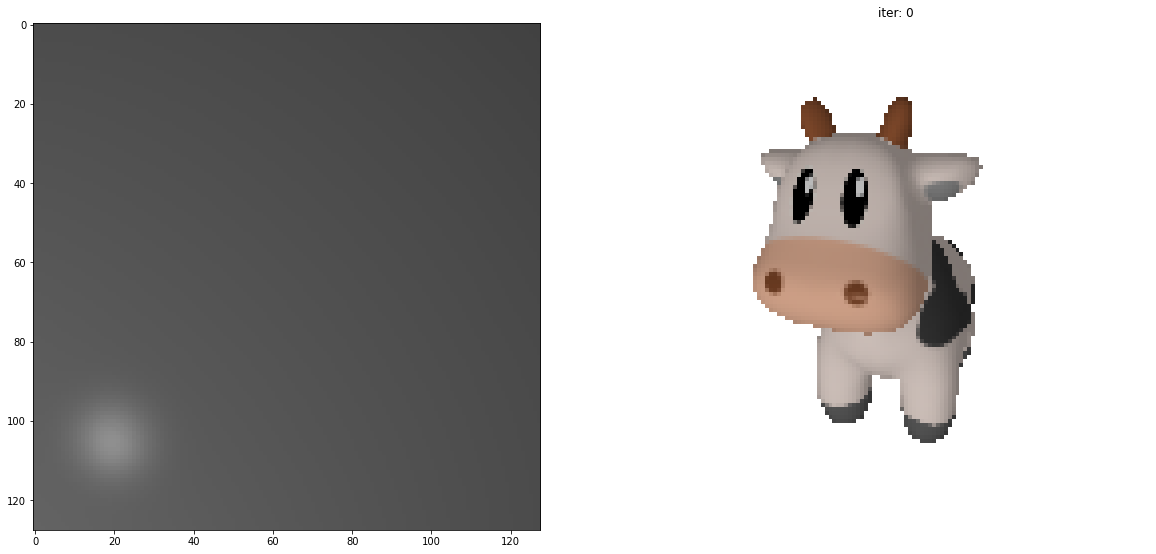

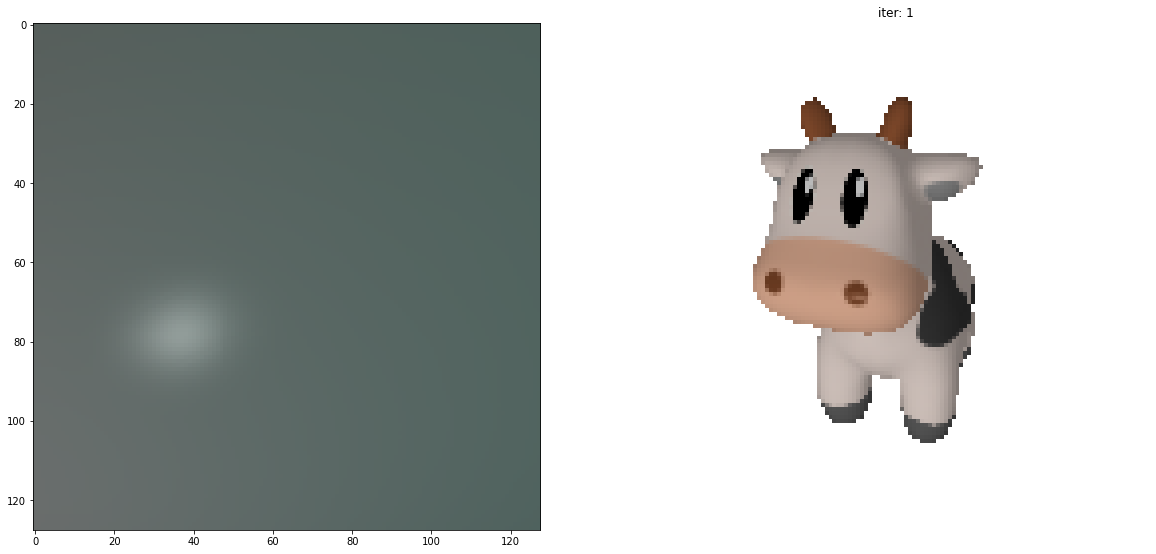

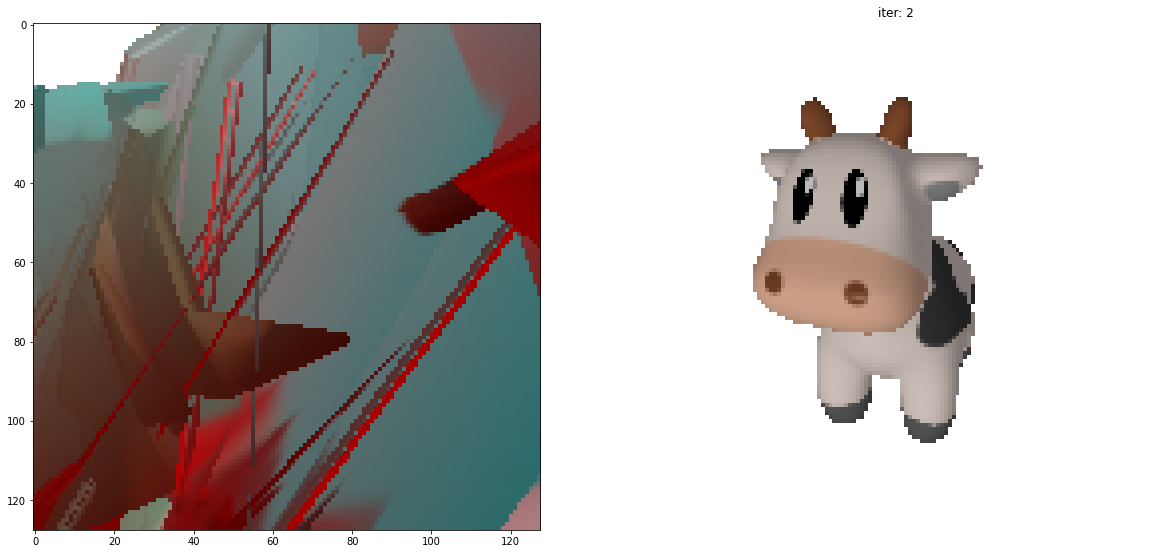

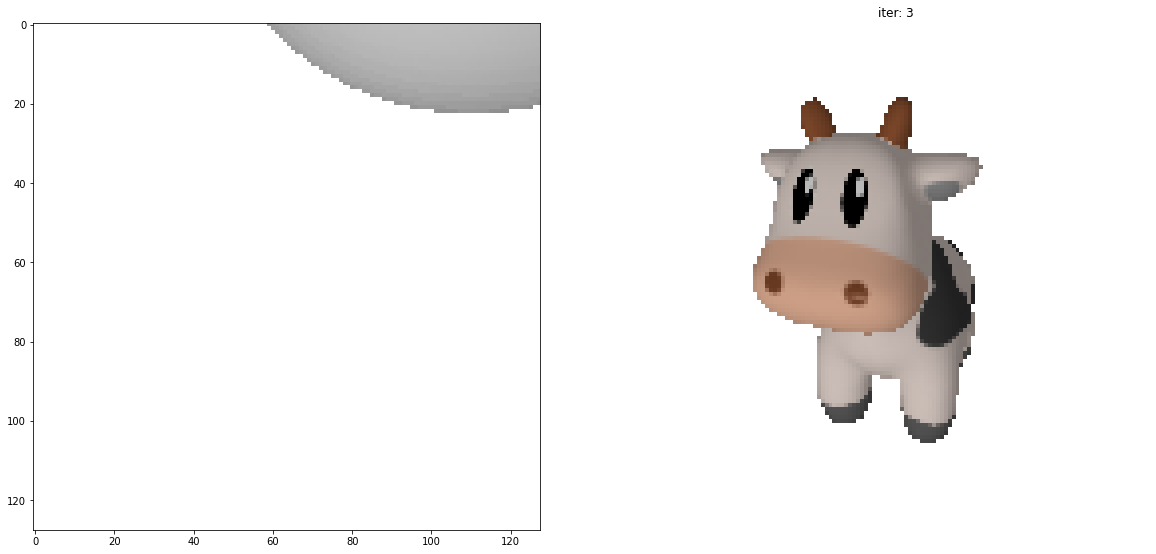

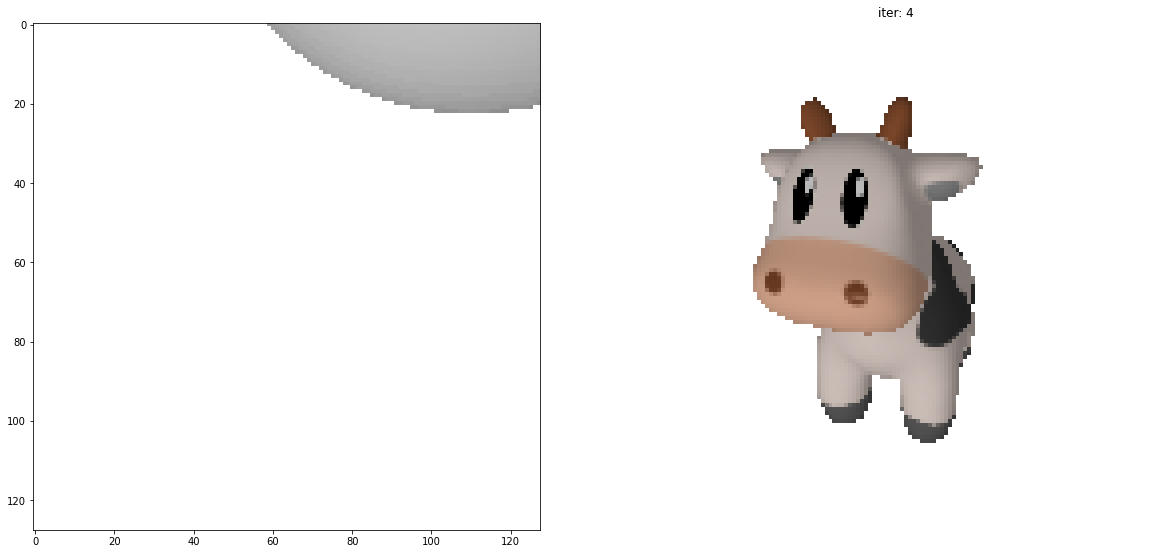

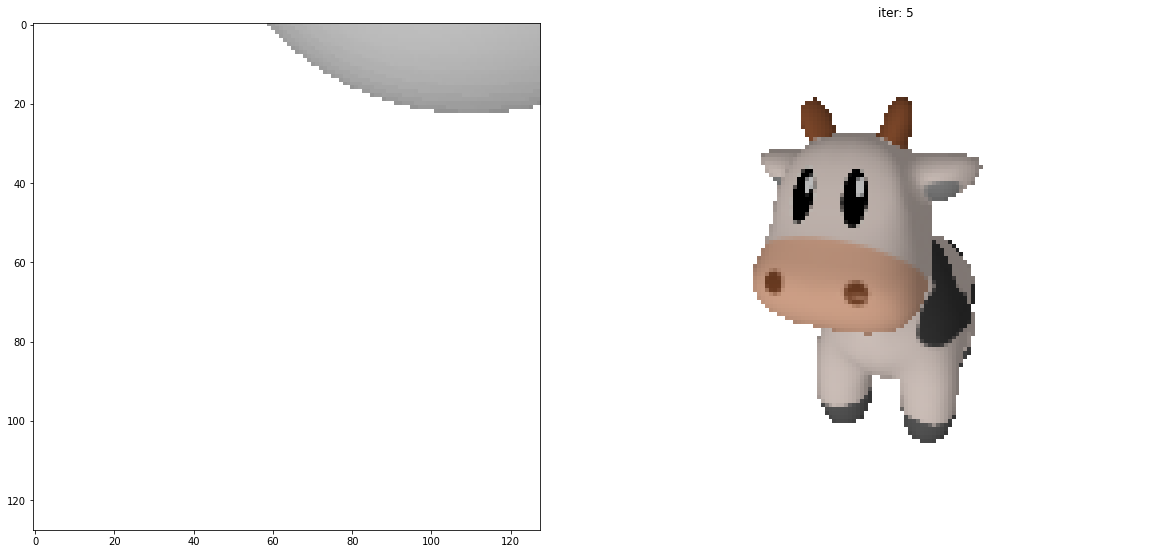

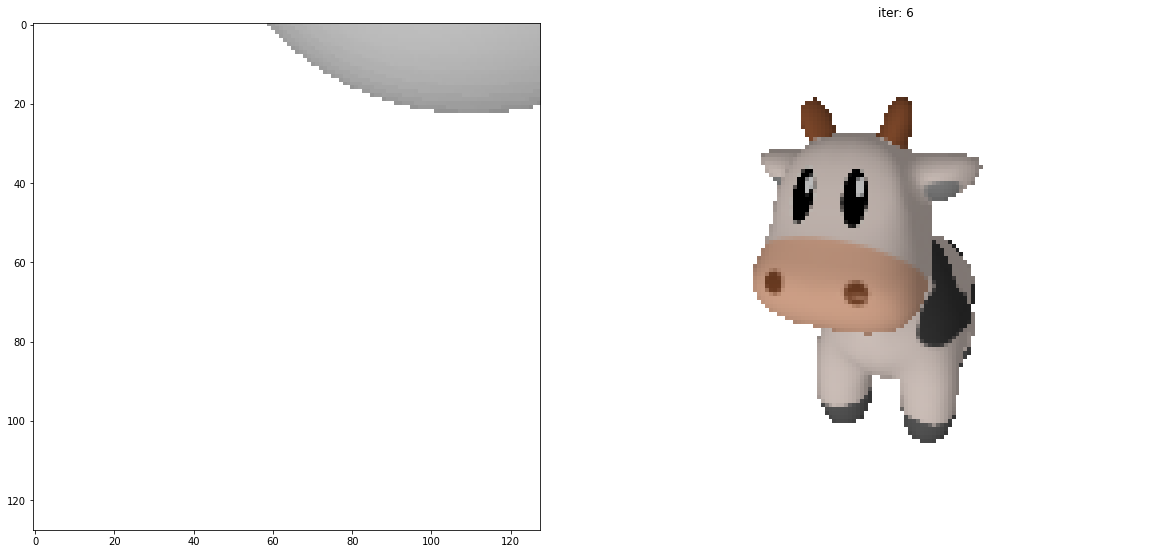

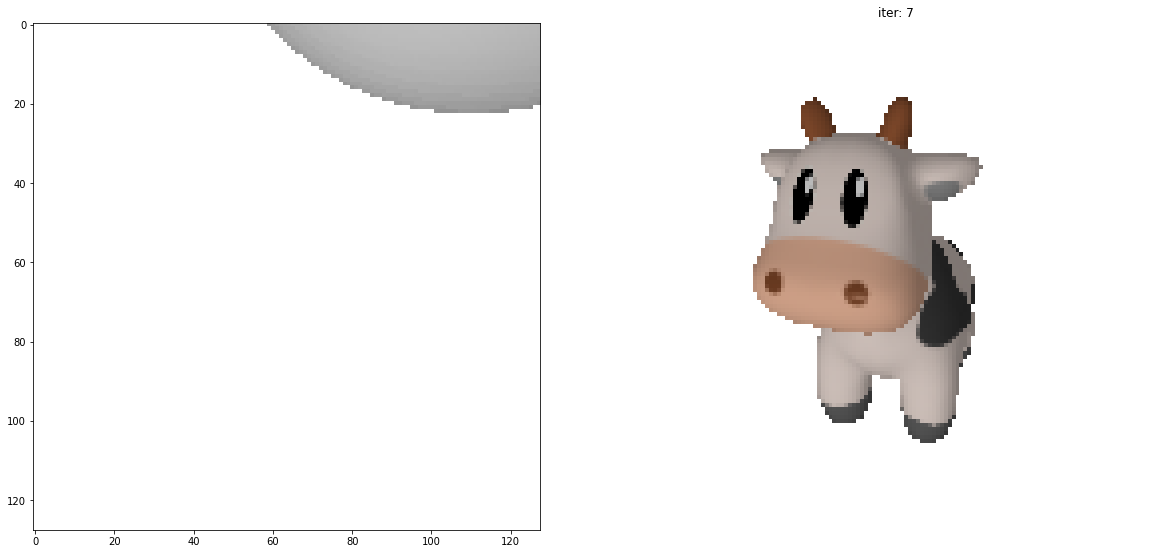

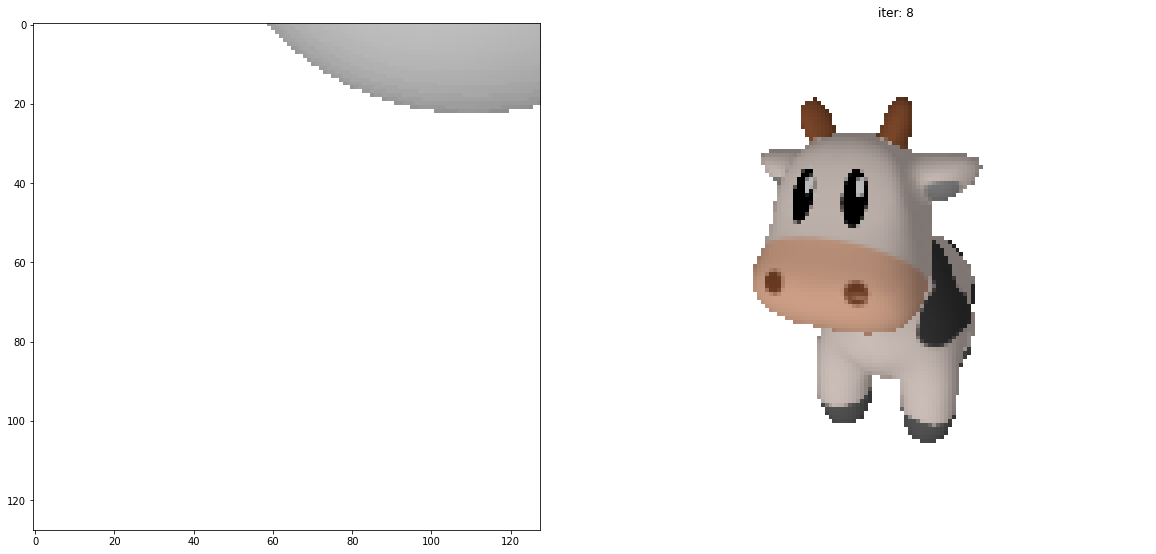

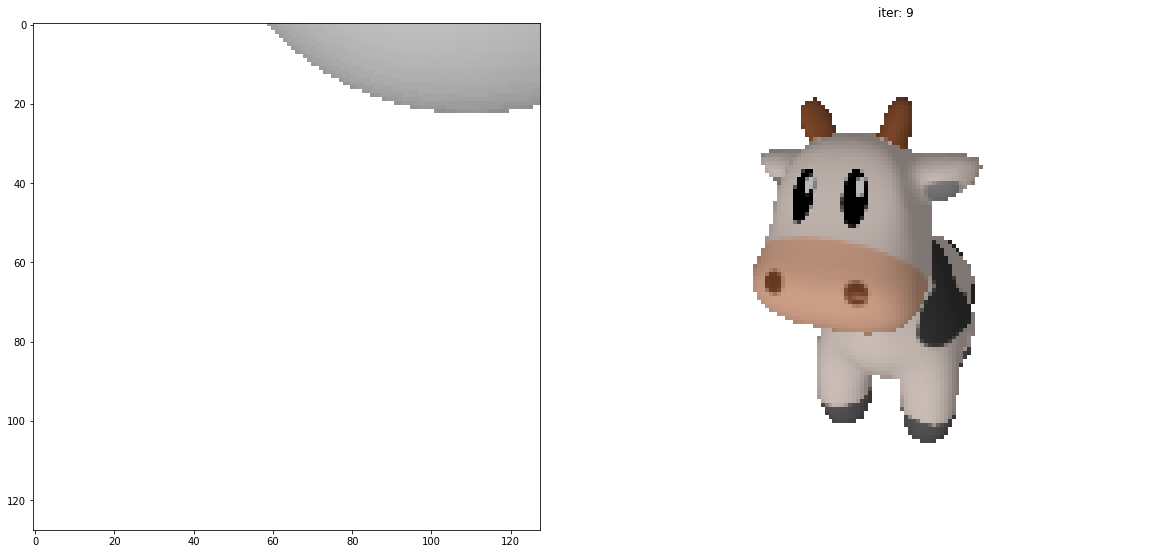

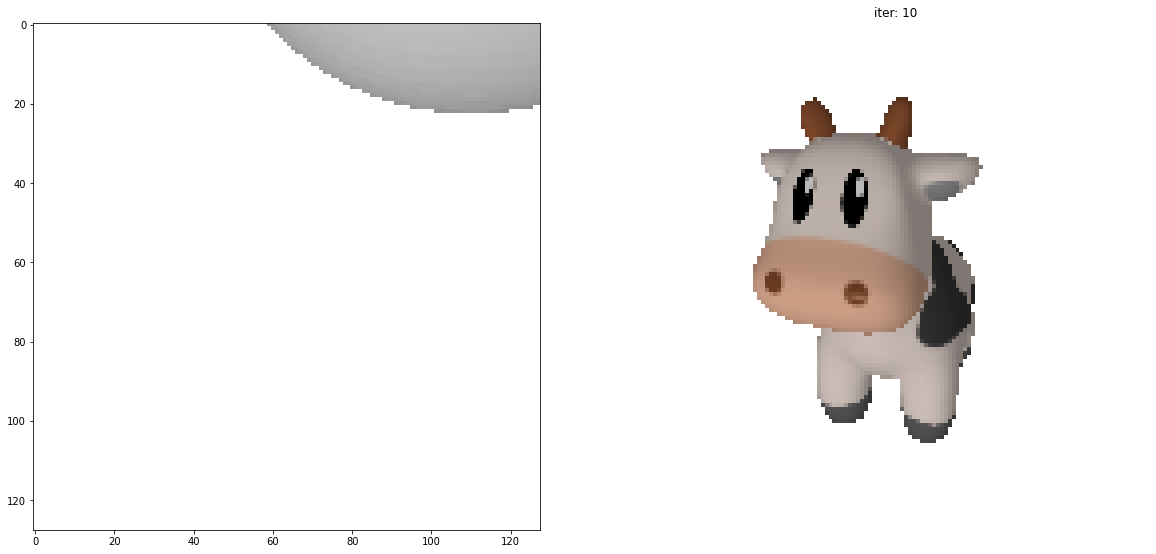

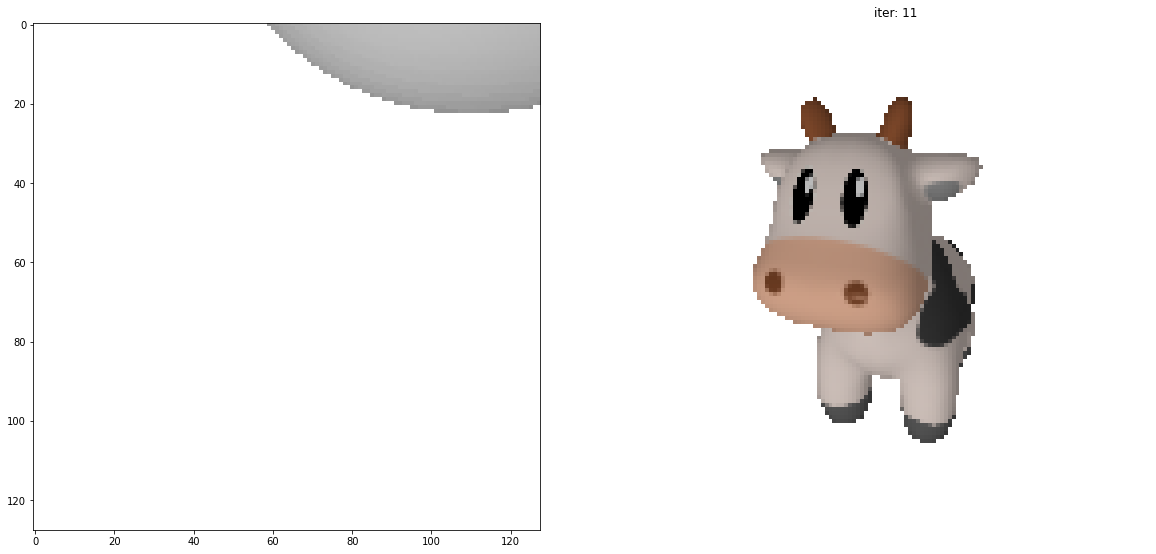

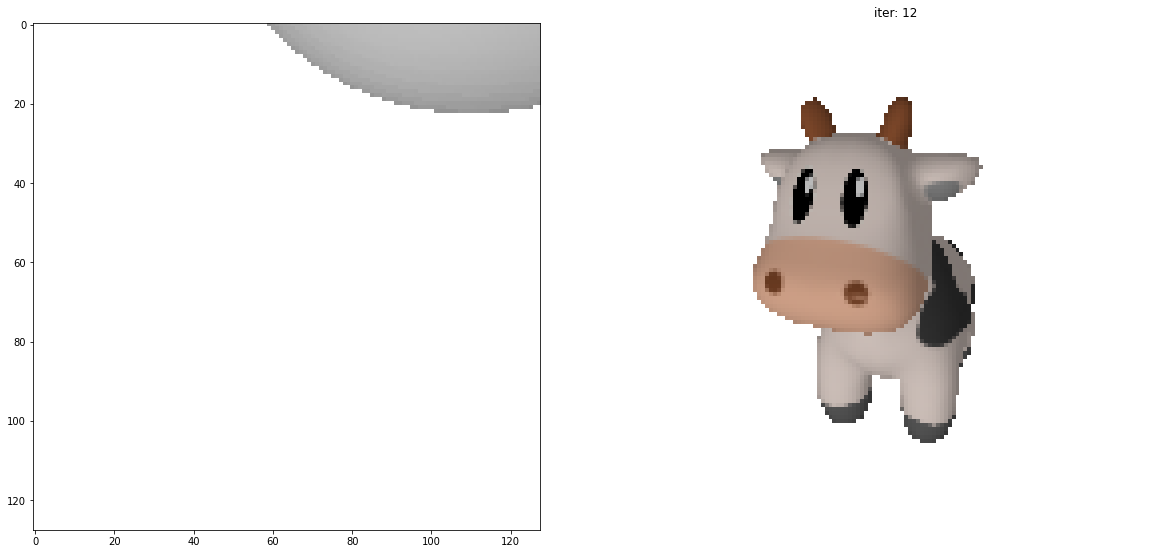

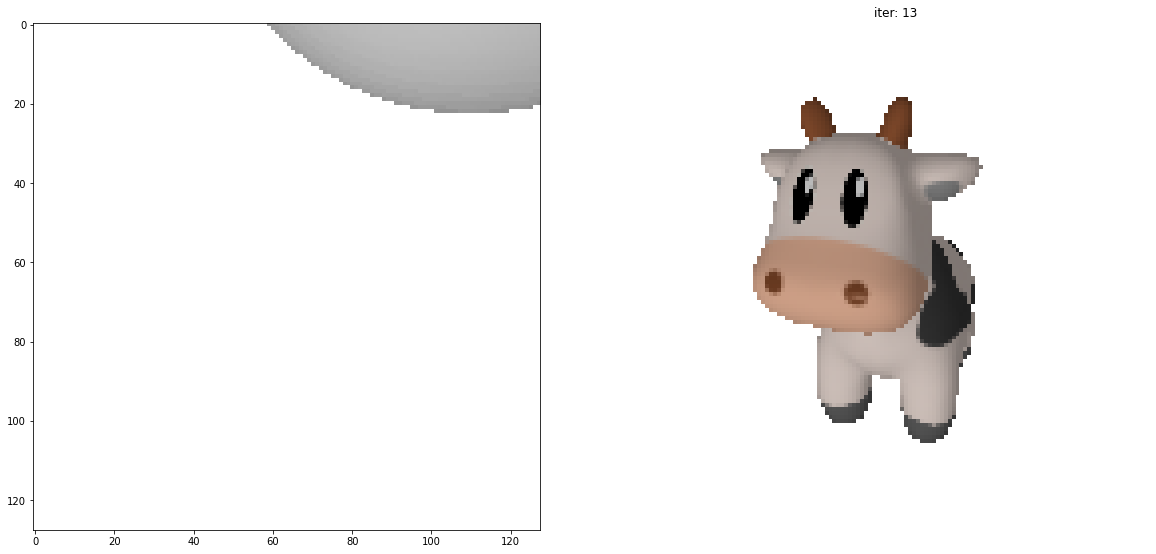

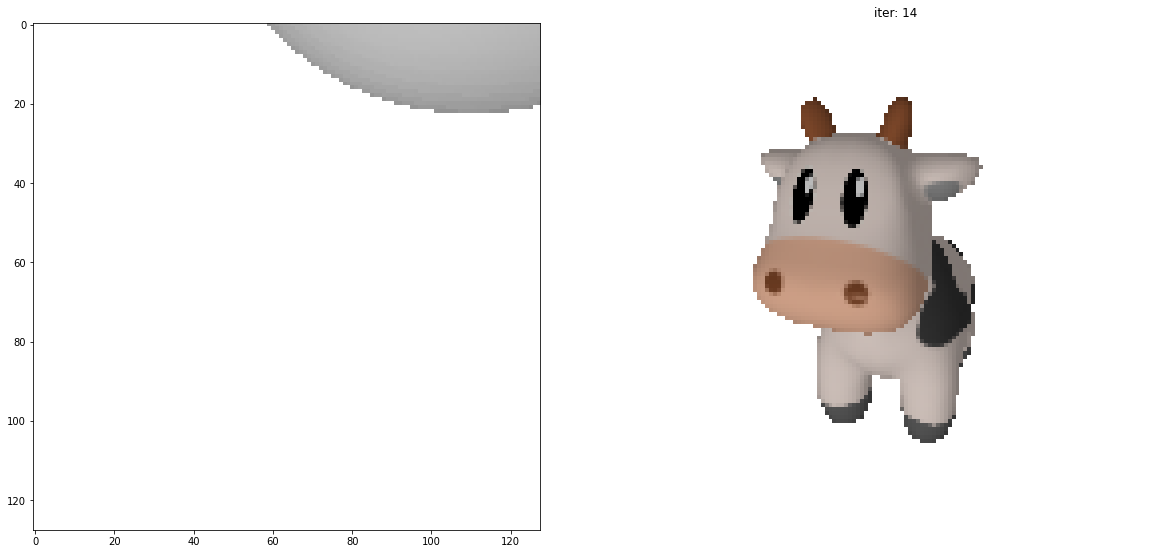

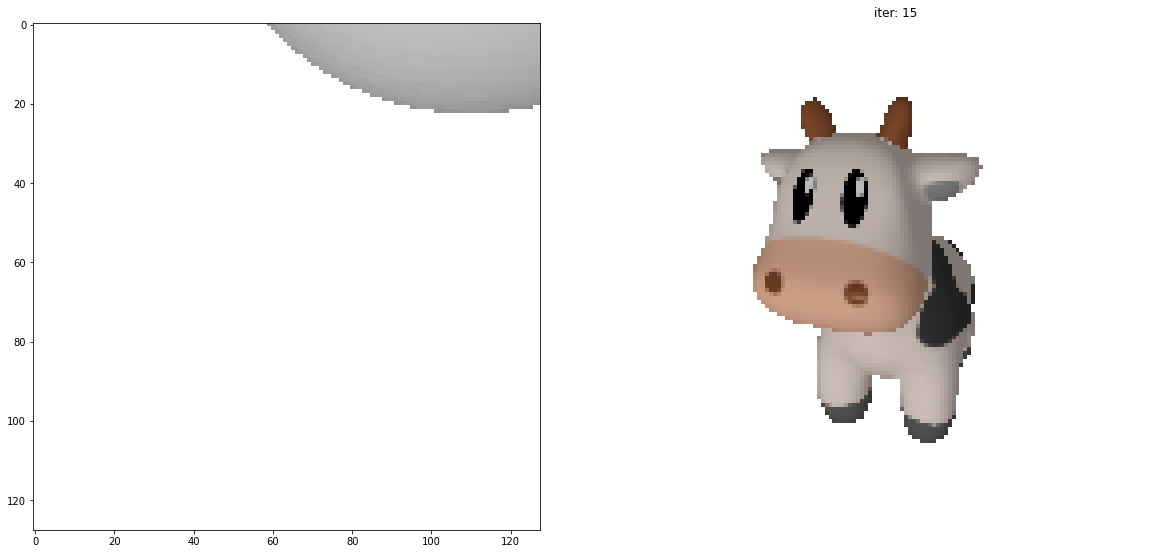

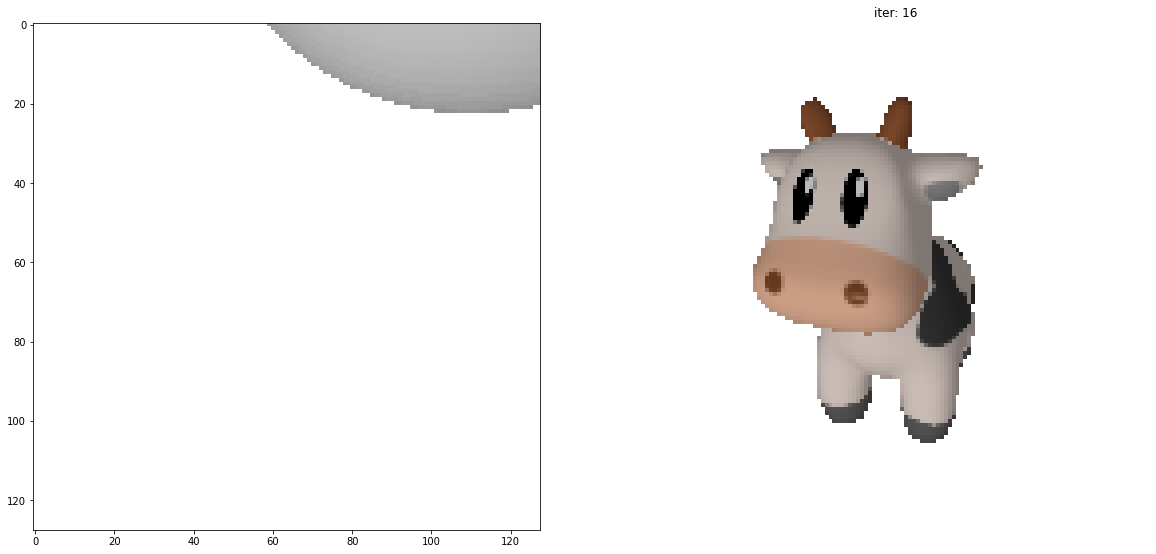

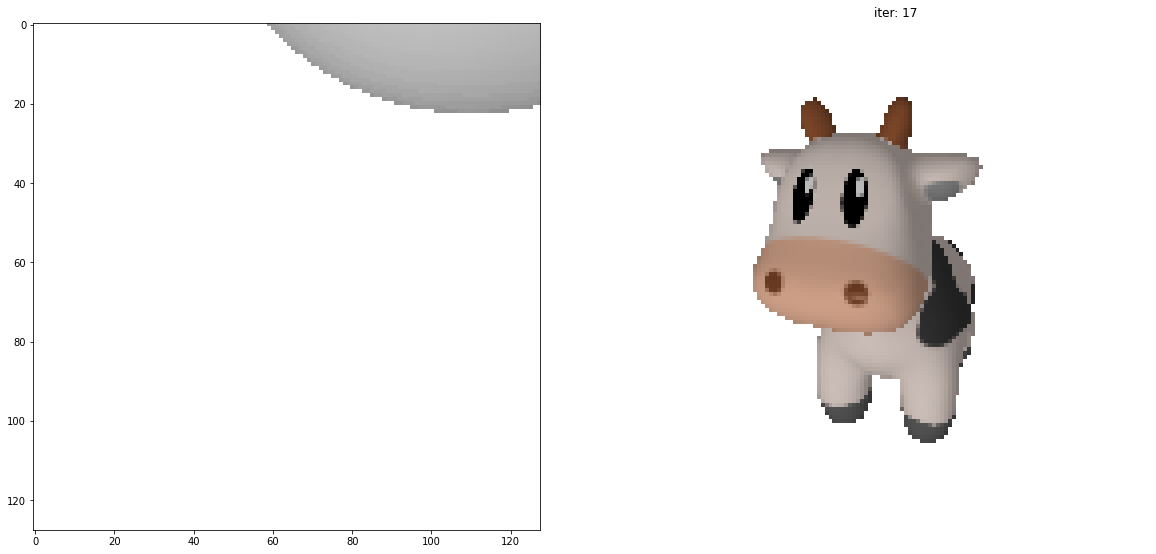

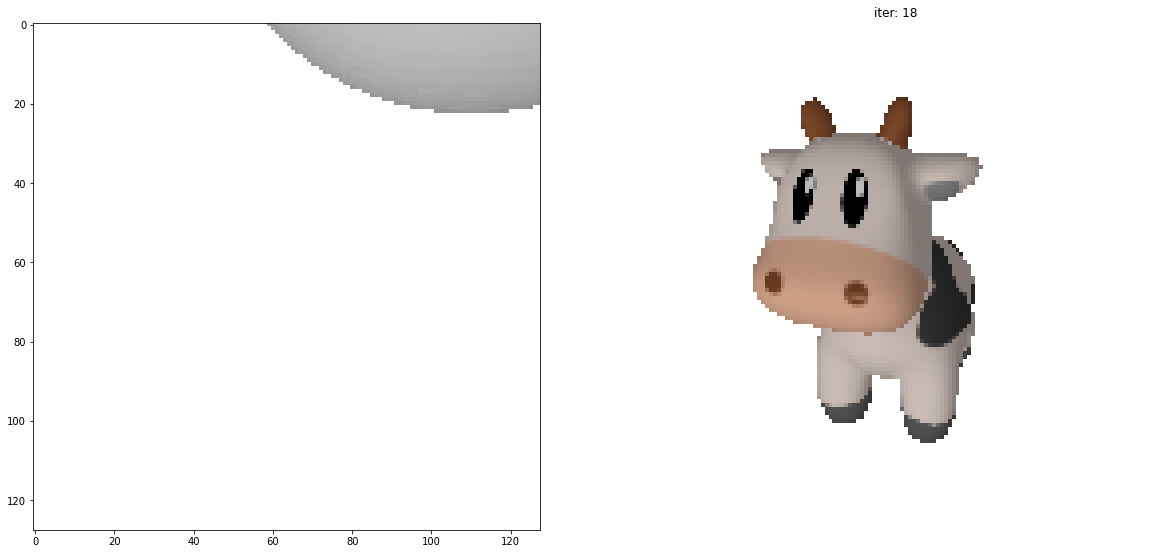

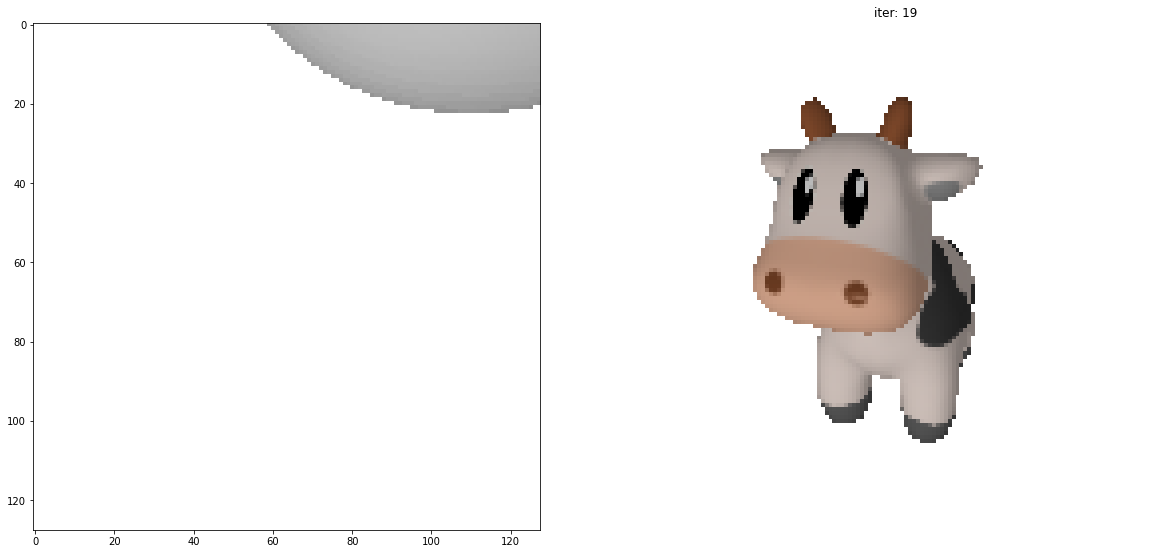

In [18]:
loop = tqdm(range(Niter))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # ------ MODEL ------
    # (2 - 5) RESNET50
    img_feats = resnet50_head(input_batch)

    # (6 - 7) BILINEAR INTERPOLATION - VOXEL PREDICTION    
    voxel_scores = voxel_head(img_feats[-1])

    # (8) CUBIFY
    meshes_out = cubify_custom(voxel_scores)
    
    # (9 - 11) REFINEMENT STAGES 1 - 3
    refined_meshes = mesh_head(img_feats, src_mesh, P)
    meshes_out = refined_meshes[-1]

    # DEFORM MESH
    new_src_mesh = src_mesh.offset_verts(meshes_out.verts_packed())
    #new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_src_mesh.textures = meshes_out.textures
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target 
        # silhouette from our dataset
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        # Squared L2 distance between the predicted RGB image and the target 
        # image from our dataset
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l)
    
    # print(new_src_mesh.verts_packed())
    
    # Print the losses
    loop.set_description("total_loss = %.6f" % loss["edge"])
    #loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
    
    # Optimization step
    sum_loss.backward()
    optimizer.step()

# 6. Rechecking model's parameters (after training)
(to compare with **before** training)

i) resnet50 parameters (**parameters don't change** after training)

In [19]:
for param in resnet50_head.parameters():
    print(param)

Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01]

Parameter containing:
tensor([ 2.1259e-03, -6.9715e-03,  9.4608e-02, -1.1439e-02,  1.4931e-01,
         1.6228e-03,  1.9745e-01,  1.8000e-02, -1.7183e-04,  1.1793e-01,
         1.0572e-02,  1.5288e-01,  6.2277e-03, -9.6050e-04,  1.0127e-01,
         1.4762e-01,  1.1484e-01,  2.5359e-02,  9.5329e-02,  2.8729e-03,
         7.1651e-02,  2.7586e-03,  1.5039e-01,  2.7510e-01,  9.0146e-02,
         1.2768e-01,  5.5667e-03,  1.3082e-01, -1.9346e-03,  5.0423e-02,
         2.1226e-03, -7.5048e-03,  1.8880e-02,  1.1878e-01,  9.8673e-02,
         7.3502e-02,  1.5206e-01,  8.6612e-02,  5.0623e-03, -1.2326e-03,
         1.1257e-01,  5.9433e-02,  1.4774e-01,  8.9319e-02,  9.7549e-02,
         6.0202e-02,  8.6732e-02,  1.5079e-01,  8.0304e-02,  2.7696e-02,
        -1.7456e-02,  1.7293e-01,  6.8518e-02,  1.4533e-01,  4.0339e-03,
         2.5851e-02,  1.8742e-01,  6.8096e-02,  1.0810e-01,  1.1762e-01,
         5.3549e-03,  7.9646e-02, -2.2026e-03,  1.5807e-01,  7.9670e-08,
         3.1757e-05,  1.1837e

Parameter containing:
tensor([[[[ 6.9636e-02]],

         [[ 3.6008e-03]],

         [[ 1.3478e-02]],

         ...,

         [[ 1.8134e-01]],

         [[ 1.9458e-03]],

         [[ 3.1590e-03]]],


        [[[-1.0936e-02]],

         [[-3.4424e-03]],

         [[ 1.6514e-02]],

         ...,

         [[ 3.2527e-03]],

         [[-3.9140e-02]],

         [[-5.9866e-03]]],


        [[[ 8.8925e-04]],

         [[ 1.0271e-03]],

         [[ 1.5778e-03]],

         ...,

         [[ 2.5194e-04]],

         [[-2.1439e-03]],

         [[-1.1421e-04]]],


        ...,


        [[[ 1.0406e-07]],

         [[ 5.3282e-08]],

         [[ 9.3874e-08]],

         ...,

         [[-3.8367e-08]],

         [[-1.5700e-07]],

         [[ 1.0596e-07]]],


        [[[ 8.8278e-03]],

         [[-2.4494e-03]],

         [[-4.0442e-02]],

         ...,

         [[ 1.2038e-02]],

         [[ 2.7628e-02]],

         [[ 1.4599e-02]]],


        [[[ 7.5303e-03]],

         [[-4.6605e-02]],

         [[-5.

Parameter containing:
tensor([0.1067, 0.1330, 0.1966, 0.2041, 0.1228, 0.1568, 0.1682, 0.1349, 0.2218,
        0.1687, 0.1892, 0.1968, 0.1744, 0.1540, 0.2011, 0.1394, 0.1831, 0.1286,
        0.1294, 0.1838, 0.1811, 0.1735, 0.1889, 0.2164, 0.1570, 0.1866, 0.1985,
        0.1465, 0.1640, 0.1273, 0.2273, 0.1822, 0.1239, 0.1486, 0.1905, 0.1189,
        0.1204, 0.1201, 0.2163, 0.1234, 0.1987, 0.2345, 0.1419, 0.1329, 0.2138,
        0.1867, 0.1982, 0.1370, 0.2064, 0.1887, 0.1521, 0.1634, 0.1765, 0.1685,
        0.1898, 0.2198, 0.1706, 0.1577, 0.1609, 0.1754, 0.1328, 0.1600, 0.1973,
        0.1794, 0.1991, 0.1767, 0.1928, 0.1742, 0.1744, 0.1367, 0.2161, 0.2227,
        0.1319, 0.1864, 0.2205, 0.1355, 0.2003, 0.1855, 0.1881, 0.1726, 0.2034,
        0.1853, 0.1983, 0.2177, 0.1946, 0.1802, 0.1104, 0.2102, 0.1276, 0.1824,
        0.1731, 0.1329, 0.1180, 0.1595, 0.1543, 0.1727, 0.1970, 0.1179, 0.1991,
        0.1621, 0.1657, 0.1119, 0.2403, 0.2070, 0.2018, 0.2244, 0.1570, 0.1642,
        0.1892, 0.

Parameter containing:
tensor([[[[ 1.4149e-02]],

         [[ 8.5007e-03]],

         [[ 1.9201e-02]],

         ...,

         [[-4.0301e-04]],

         [[-1.6396e-02]],

         [[ 6.3780e-03]]],


        [[[-7.8159e-03]],

         [[-1.5656e-04]],

         [[ 1.0262e-02]],

         ...,

         [[ 5.9090e-03]],

         [[ 8.4134e-02]],

         [[-2.8860e-03]]],


        [[[ 2.2822e-02]],

         [[-4.3230e-02]],

         [[ 7.8770e-03]],

         ...,

         [[ 1.4022e-02]],

         [[ 6.7142e-03]],

         [[-3.1446e-02]]],


        ...,


        [[[-8.5522e-05]],

         [[ 8.2215e-03]],

         [[-2.0979e-02]],

         ...,

         [[-1.9268e-02]],

         [[-1.8546e-02]],

         [[ 3.3627e-02]]],


        [[[-1.2550e-02]],

         [[-5.8194e-02]],

         [[ 5.3627e-03]],

         ...,

         [[ 7.3295e-03]],

         [[ 2.6446e-02]],

         [[ 3.0675e-02]]],


        [[[-3.8911e-03]],

         [[-2.7051e-02]],

         [[-2.

Parameter containing:
tensor([0.0480, 0.0825, 0.1115,  ..., 0.1348, 0.1069, 0.1080], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0647, -0.0260, -0.0057,  ..., -0.0232, -0.0627, -0.0947],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[ 0.0029]],

         [[-0.0284]],

         [[-0.0025]],

         ...,

         [[-0.0419]],

         [[-0.0272]],

         [[-0.0104]]],


        [[[-0.0124]],

         [[-0.0031]],

         [[ 0.0118]],

         ...,

         [[ 0.0464]],

         [[-0.0031]],

         [[ 0.0227]]],


        [[[ 0.0035]],

         [[-0.0278]],

         [[ 0.0191]],

         ...,

         [[-0.0063]],

         [[-0.0314]],

         [[ 0.0138]]],


        ...,


        [[[ 0.0059]],

         [[ 0.0059]],

         [[ 0.0039]],

         ...,

         [[-0.0128]],

         [[-0.0166]],

         [[ 0.0112]]],


        [[[ 0.0152]],

         [[-0.0092]],

         [[-0.0080]],

         .

Parameter containing:
tensor([0.1289, 0.1811, 0.1434, 0.1497, 0.1642, 0.2092, 0.1794, 0.1881, 0.1535,
        0.1468, 0.1609, 0.1833, 0.1200, 0.1987, 0.1594, 0.1837, 0.2195, 0.1638,
        0.1447, 0.2000, 0.1600, 0.1625, 0.1672, 0.1554, 0.1694, 0.1334, 0.1867,
        0.1898, 0.1418, 0.1985, 0.2040, 0.1359, 0.2024, 0.1679, 0.1409, 0.1710,
        0.1171, 0.1267, 0.1705, 0.1479, 0.1864, 0.1502, 0.2114, 0.2251, 0.1741,
        0.1688, 0.1057, 0.1641, 0.1542, 0.1765, 0.1358, 0.1193, 0.1366, 0.1934,
        0.1655, 0.1889, 0.1728, 0.1615, 0.1355, 0.1368, 0.1782, 0.1291, 0.1392,
        0.1907, 0.1541, 0.1765, 0.1072, 0.1467, 0.1842, 0.1374, 0.1605, 0.1637,
        0.1314, 0.1463, 0.2017, 0.1425, 0.1926, 0.1525, 0.1305, 0.1450, 0.1296,
        0.1885, 0.1971, 0.1925, 0.1545, 0.1706, 0.2379, 0.2122, 0.1125, 0.1800,
        0.1602, 0.2117, 0.1842, 0.1107, 0.1372, 0.2442, 0.1042, 0.1182, 0.0949,
        0.1530, 0.2418, 0.1407, 0.1725, 0.1684, 0.1633, 0.1663, 0.1553, 0.1665,
        0.1538, 0.

Parameter containing:
tensor([-0.2308, -0.1761, -0.0937, -0.1531, -0.2710,  0.0623, -0.1275, -0.1807,
        -0.2341, -0.1118, -0.2037, -0.2124, -0.1777, -0.2047, -0.2234, -0.1634,
        -0.2535, -0.2236, -0.1890, -0.0604, -0.1507, -0.1673, -0.1038, -0.0869,
        -0.1487, -0.1072, -0.2277, -0.2578, -0.1459, -0.2438, -0.0822, -0.0670,
        -0.2275, -0.1194, -0.1724, -0.1303, -0.1969, -0.1824, -0.1828, -0.2419,
        -0.1568, -0.2165, -0.1494, -0.1369, -0.2610, -0.1064, -0.1072, -0.2473,
        -0.2436,  0.0821, -0.2224, -0.1274, -0.1208, -0.2416, -0.2440, -0.2850,
        -0.1709, -0.0610, -0.1020, -0.2847, -0.1033, -0.1511, -0.2111, -0.1366,
        -0.1880, -0.1200, -0.1406, -0.0585, -0.2489, -0.1252, -0.2507, -0.1156,
        -0.2484, -0.1786, -0.1779, -0.0934, -0.1713, -0.1485, -0.2675, -0.2188,
        -0.2363, -0.1913, -0.1279, -0.0951, -0.1292, -0.2095, -0.0947, -0.1581,
        -0.0322, -0.2477, -0.2326, -0.1597, -0.1734, -0.1965, -0.1505, -0.1968,
        -0.1474, -

Parameter containing:
tensor([-1.3754e-01, -1.4396e-01, -8.4855e-02, -1.4970e-01, -1.8841e-01,
        -1.6617e-01, -4.8700e-02, -9.0149e-02, -1.0600e-01, -9.7357e-02,
        -1.3883e-01, -1.7422e-01, -1.4749e-01, -1.2698e-01, -1.2006e-01,
        -1.2456e-01, -1.5032e-01, -1.3609e-01, -1.3015e-01, -1.0686e-01,
        -1.1018e-01, -1.2958e-01, -8.3334e-02, -1.2276e-01, -1.5828e-01,
        -1.2241e-01, -5.4720e-02, -9.3192e-02, -1.4402e-01, -1.3055e-01,
        -9.7630e-02, -1.1088e-01, -1.7261e-01, -4.3580e-02, -1.6754e-01,
        -8.3284e-02, -1.2409e-01, -9.7850e-02, -1.0157e-01, -1.6108e-01,
        -1.5655e-01, -7.0632e-02, -1.0094e-01, -8.5716e-02, -1.1538e-01,
        -7.0626e-02, -9.6296e-02, -1.3053e-01, -1.0154e-01, -1.5348e-01,
        -1.2131e-01, -6.3897e-02, -2.9110e-02, -1.4233e-01, -1.3902e-01,
        -1.2259e-01, -1.1752e-01, -1.7453e-01, -1.1942e-01, -2.7141e-01,
        -1.2023e-01, -1.4816e-01, -1.6105e-01, -1.0797e-01,  2.2307e-04,
        -1.4663e-01, -1.3773e

ii) voxel_head parameters (**parameters don't change** after training)

In [20]:
for param in voxel_head.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0164,  0.0088, -0.0680],
          [ 0.0346,  0.0130, -0.0402],
          [-0.0002, -0.0055, -0.0162]],

         [[-0.0334, -0.0516,  0.0322],
          [-0.0080, -0.0269,  0.0026],
          [-0.0361, -0.0101,  0.0103]],

         [[ 0.0244,  0.0170,  0.0270],
          [ 0.0046, -0.0540,  0.0274],
          [ 0.0718, -0.0209, -0.0492]],

         ...,

         [[-0.0011, -0.0095,  0.0557],
          [-0.0022,  0.0392,  0.0630],
          [ 0.0189, -0.0046, -0.0208]],

         [[-0.0194, -0.0105, -0.0016],
          [ 0.0179,  0.0022, -0.0041],
          [ 0.0414, -0.0391,  0.0100]],

         [[ 0.0012, -0.0255,  0.0176],
          [ 0.0125, -0.0611,  0.0270],
          [-0.0243, -0.0024,  0.0006]]],


        [[[ 0.0105,  0.0464,  0.0162],
          [-0.0111, -0.0402,  0.0215],
          [ 0.0092, -0.0186, -0.0359]],

         [[ 0.0116,  0.0299,  0.0328],
          [-0.0243, -0.0125, -0.0125],
          [-0.0469,  0.0788, -0.0353]],

         

iii) mesh_head parameters (**parameters change** after training)

In [21]:
for param in mesh_head.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0099,  0.0191,  0.0097,  ...,  0.0056,  0.0083,  0.0154],
        [ 0.0175,  0.0201, -0.0031,  ...,  0.0259,  0.0490,  0.0472],
        [-0.0064,  0.0151,  0.0175,  ..., -0.0088,  0.0171,  0.0076],
        ...,
        [-0.0064,  0.0044, -0.0097,  ...,  0.0014, -0.0017,  0.0138],
        [-0.0072, -0.0036,  0.0139,  ..., -0.0004,  0.0190,  0.0039],
        [ 0.0129, -0.0048, -0.0007,  ..., -0.0023, -0.0183, -0.0030]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-7.0389e-02,  1.5454e-01,  7.5771e-03, -8.7144e-02,  1.1653e-01,
        -6.2932e-03,  1.5008e-02,  6.9484e-02, -1.3141e-02,  3.6608e-03,
        -2.8928e-02,  7.8971e-02, -2.0037e-03,  1.0394e-02,  0.0000e+00,
        -1.5591e-02, -3.4918e-03, -6.9734e-02, -4.1455e-02, -6.6652e-02,
         3.0146e-05, -1.7176e-02,  7.2036e-04,  0.0000e+00,  3.6719e-05,
        -2.5239e-02,  5.2621e-02,  2.2906e-02, -6.3607e-03,  8.9231e-03,
         3.2988e-02,  2.8076e-03,  5.156

Parameter containing:
tensor([[ 6.5436e-02, -1.8814e-01, -6.0153e-02,  ...,  7.9722e-01,
         -2.3575e-01, -1.4325e-01],
        [ 8.0160e-02,  1.7597e-02, -4.3954e-03,  ...,  2.2638e-01,
         -5.4976e-01,  1.4936e-02],
        [ 1.8923e-02,  5.9148e-04,  1.3456e-02,  ...,  1.8665e-01,
         -1.0265e-01,  1.2794e-02],
        ...,
        [-1.8240e-02, -6.7333e-03,  8.7574e-03,  ..., -2.1586e-02,
          5.9961e-02, -5.4411e-02],
        [ 1.1598e-02, -2.1547e-03,  1.0546e-02,  ...,  3.5953e-03,
         -1.9538e-02,  1.8830e-03],
        [ 3.2766e-04, -6.6789e-02, -3.7861e-03,  ...,  9.9914e-02,
          3.9633e-02, -3.0614e-02]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1.1295e-01,  3.4498e-02,  1.9409e-02,  1.4750e-02, -1.1502e-02,
        -2.3640e-01, -2.0262e-01, -3.9476e-03, -2.0280e-02,  3.1869e-01,
         1.6019e-01, -1.2936e-01,  8.1992e-02,  2.1068e-01,  8.9560e-03,
         3.4627e-02,  1.0250e-01, -1.7146e-01,  1.7726e-02, -5.5368e

Parameter containing:
tensor([[-1.1130e+00, -5.4921e-01, -2.0721e-01,  ..., -5.4825e-02,
         -9.1618e-01, -7.8068e-01],
        [-1.8621e-02, -1.2571e-02,  1.1523e-02,  ...,  1.7804e-02,
         -1.6445e-02, -3.4164e-03],
        [ 3.2862e-03,  3.8239e-03, -1.0172e-02,  ...,  4.1162e-02,
          4.8790e-02, -1.5192e-03],
        ...,
        [-1.9350e+00, -1.2941e+00, -2.4419e-01,  ...,  2.0883e+00,
         -9.8221e-01, -1.2935e+00],
        [-5.3453e-03,  4.2798e-04,  2.1976e-03,  ..., -2.4509e-02,
         -3.1341e-02, -2.5041e-02],
        [-2.4229e-02,  2.7147e-03, -1.1126e-02,  ..., -5.8875e-01,
          8.1697e-02, -2.7990e-02]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-8.1318e-01, -1.6011e-03, -1.9775e-04,  3.4764e-01,  3.3078e-03,
        -2.6750e-02,  6.0430e-01,  3.6579e-04,  3.4909e-04, -1.5168e+00,
         1.1241e-03,  4.2101e-01, -2.3211e+00, -2.2892e-02, -1.6922e-01,
        -1.6152e-02,  5.0232e-01,  2.1883e-01, -3.5683e-02,  2.0703e

Parameter containing:
tensor([ 0.1224,  0.0031,  0.0024, -0.0335, -0.0107, -0.0079, -0.0105,  0.0142,
         0.0290, -0.0439, -0.0272, -0.0393,  0.0067, -0.0126, -0.0417, -0.0189,
         0.0078,  0.0925, -0.0206, -0.0348, -0.0091,  0.0638,  0.0470,  0.0212,
        -0.0076, -0.0071, -0.0327,  0.0503,  0.0696,  0.0115,  0.0049,  0.0672,
         0.0183, -0.0029, -0.0216,  0.0091,  0.0104,  0.0219,  0.0612,  0.0179,
         0.0029,  0.0011,  0.0046, -0.0273, -0.0136, -0.0277,  0.0025,  0.0035,
         0.0071,  0.0384,  0.0009,  0.0095,  0.0348, -0.0373, -0.0097,  0.0088,
         0.0091,  0.0150, -0.0047, -0.0185,  0.0472, -0.0229, -0.0218,  0.1455,
        -0.0039, -0.0166,  0.0449, -0.0751,  0.0327,  0.0228,  0.1283,  0.0579,
        -0.0408, -0.0360, -0.0012, -0.0021,  0.0751, -0.0803,  0.0654,  0.0242,
        -0.0674,  0.0413,  0.0091,  0.0201,  0.0092, -0.0338,  0.1502, -0.0431,
         0.0323,  0.0043,  0.0124,  0.0276, -0.0074,  0.0294,  0.0200,  0.0524,
        -0.0138,  